# pySCENIC protocol: PBMC10k
May 2025

In [29]:
# import dependencies
import pyscenic
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
from dask.diagnostics import ProgressBar
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns



from multiprocessing import cpu_count
from operator import concat
from typing import Callable, Sequence, Type, TypeVar

import pandas as pd
from boltons.iterutils import chunked_iter
from ctxcore.genesig import GeneSignature, Regulon
from ctxcore.rnkdb import MemoryDecorator, RankingDatabase
from dask import delayed
from dask.dataframe import from_delayed
from dask.distributed import Client, LocalCluster
from multiprocessing_on_dill.connection import Pipe
from multiprocessing_on_dill.context import Process

In [10]:
# set variables for file paths to read from and write to:

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output (with filtering applied)
f_pyscenic_output = "pyscenic_output_5_7.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'pbmc10k_scenic_integrated-output_5_7.loom'


In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.9
scanpy      1.10.3
-----
MulticoreTSNE               NA
PIL                         8.3.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
boltons                     NA
certifi                     2021.05.30
cffi                        1.14.6
charset_normalizer          2.0.4
click                       8.1.8
cloudpickle                 3.1.1
ctxcore                     0.2.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     1.0.1
dask                        2024.2.1
dateutil                    2.8.2
decorator                   5.0.9
defusedxml                  0.7.1
dill                        0.3.9
distributed                 2024.2.1
entrypoints                 0.3
exceptiongroup              1.2.2
frozendict                  2.4.6
fsspec                      2025.2.0
h5py                        3.13

In [6]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

## Expression data import

In [35]:
# Load the .h5ad file
adata = sc.read('/u/scratch/p/priyalsh/tcell_for_pyscenic_steps.h5ad')
#adata = sc.read_loom( f_loom_path_unfilt )

In [7]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "Stimulation": np.array(adata.obs.stimulation) ,
    "CD_Status": np.array(adata.obs.cd_status), 
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )



## Basic Filtering

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# read unfiltered data from a loom file
# adata = sc.read_loom( f_loom_path_unfilt )

In [36]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0  -  6802657
Number of cells in which each gene is detected: 0  -  47725


In [38]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  1431.78
minSamples:  477.26


In [39]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)

# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell, compute the fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

In [40]:
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

# Diagnostic Plots (pre-filtering)

Number of genes expressed per cell

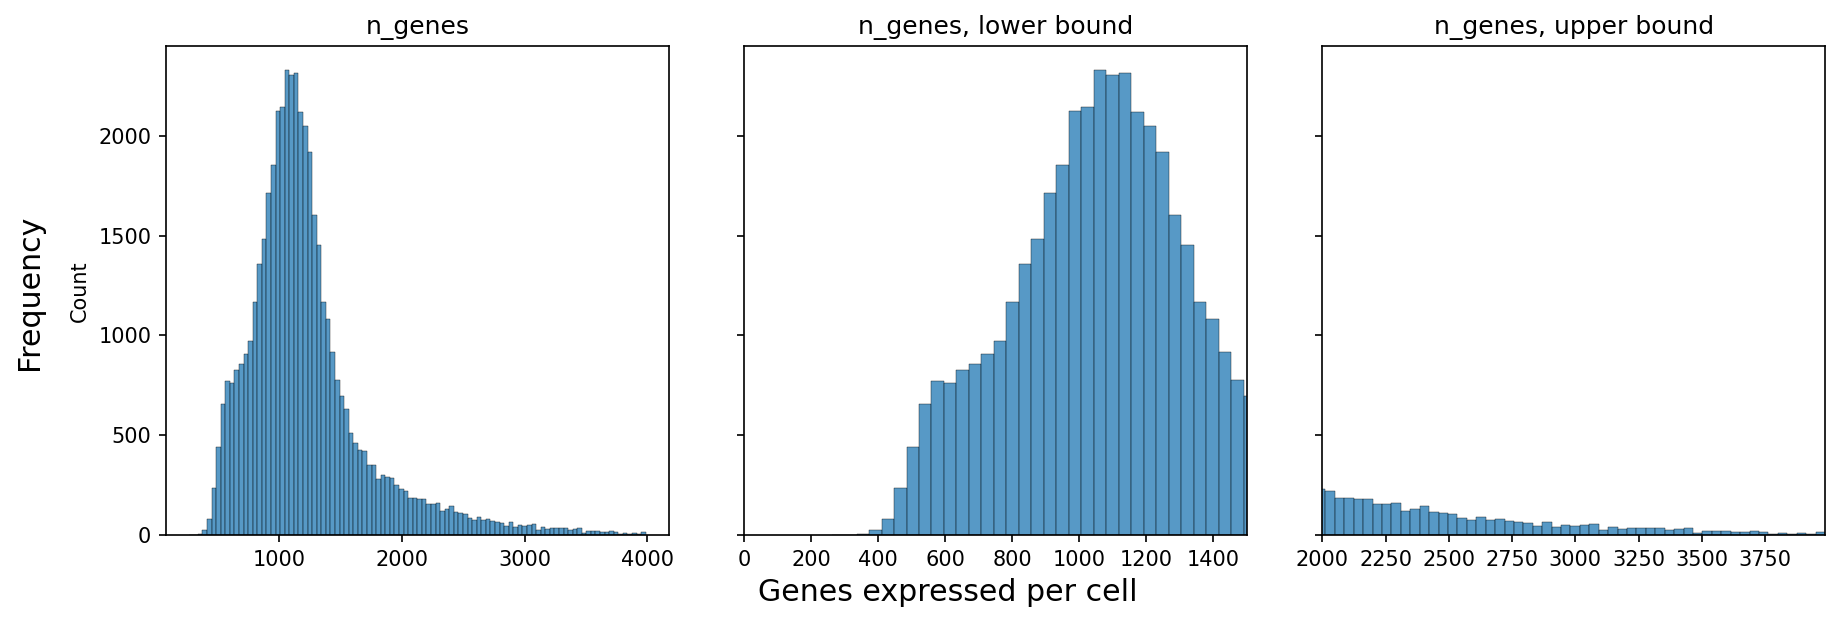

In [32]:
import matplotlib.pyplot as plt


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.histplot(x, ax=ax1, bins=nbins)
sns.histplot(x, ax=ax2, bins=nbins)
sns.histplot(x, ax=ax3,bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Percentage of mitochondrial reads per cell

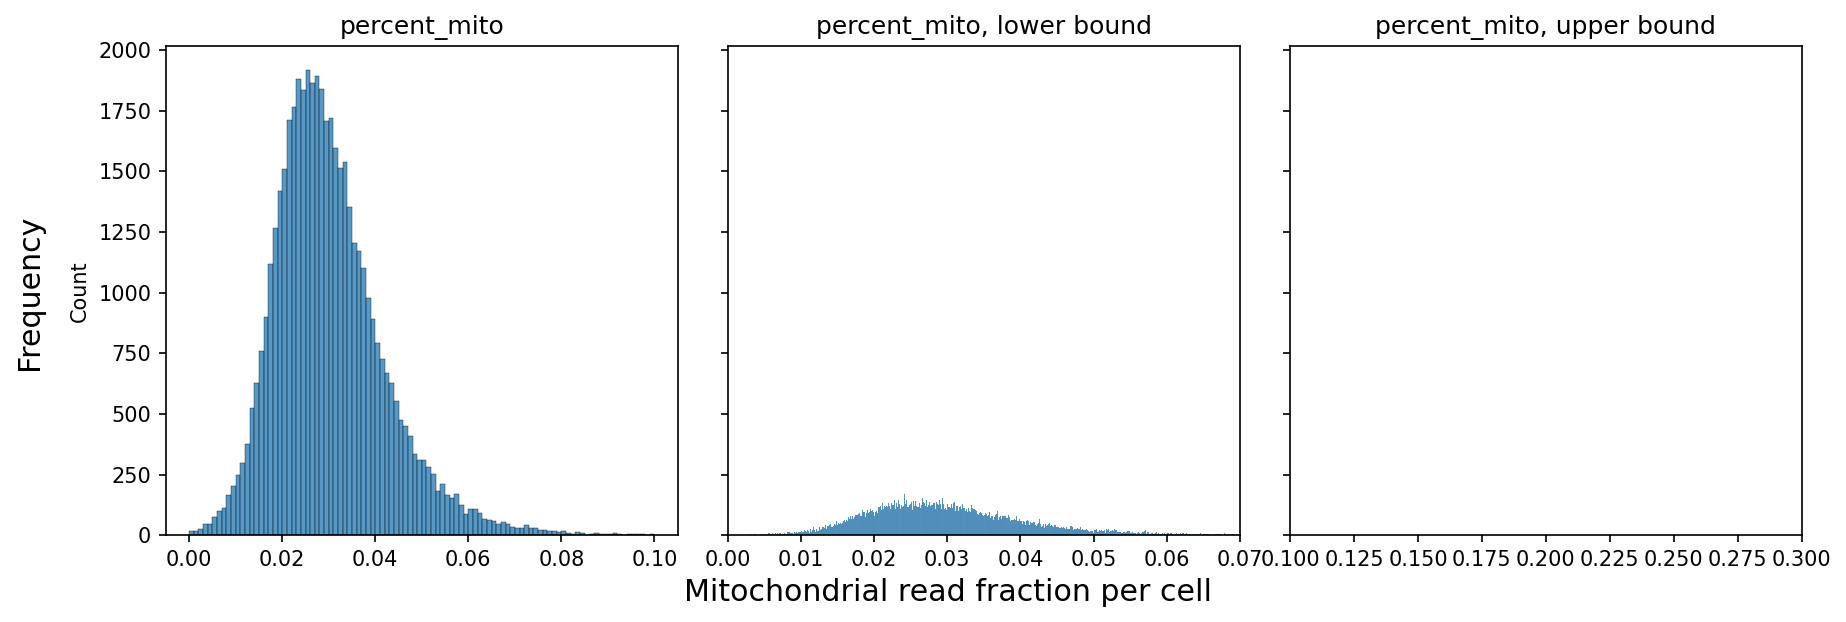

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.histplot(x, ax=ax1,bins=nbins)
sns.histplot(x, ax=ax2,  bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.histplot(x, ax=ax3, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Three-panel summary plots

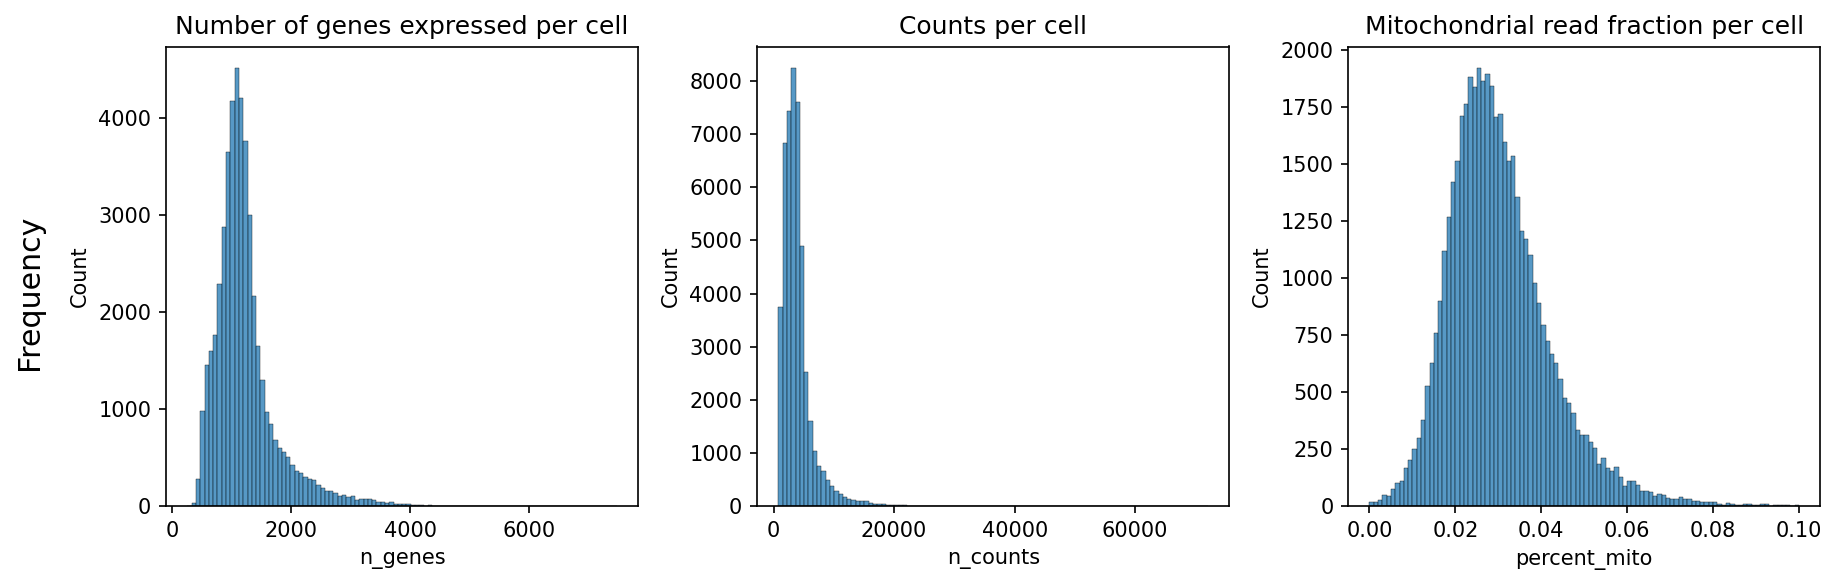

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.histplot( adata.obs['n_genes'], ax=ax1, bins=100)
sns.histplot( adata.obs['n_counts'], ax=ax2, bins=100)
sns.histplot( adata.obs['percent_mito'], ax=ax3, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

Violin Plot

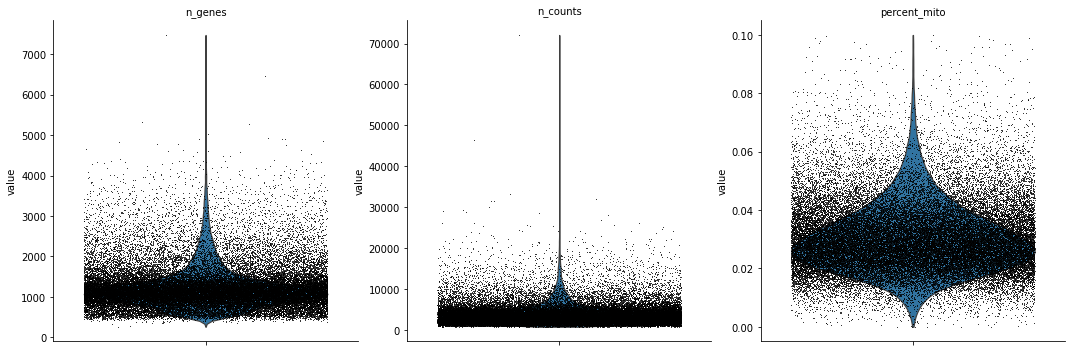

In [44]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

Scatter plot, n_genes by n_counts

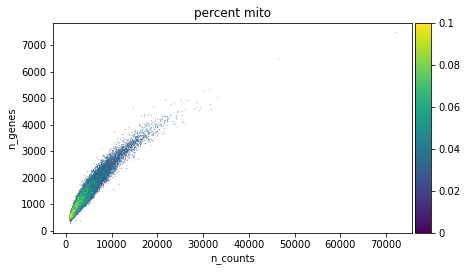

In [45]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

# Filtering

In [13]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 27246 genes that are detected in less than 3 cells


In [14]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

In [17]:
#Finalize the filters
adata.write( f_anndata_path )

# Diagnostic Plots(Post Filtering)

Three-Panel Summary plots

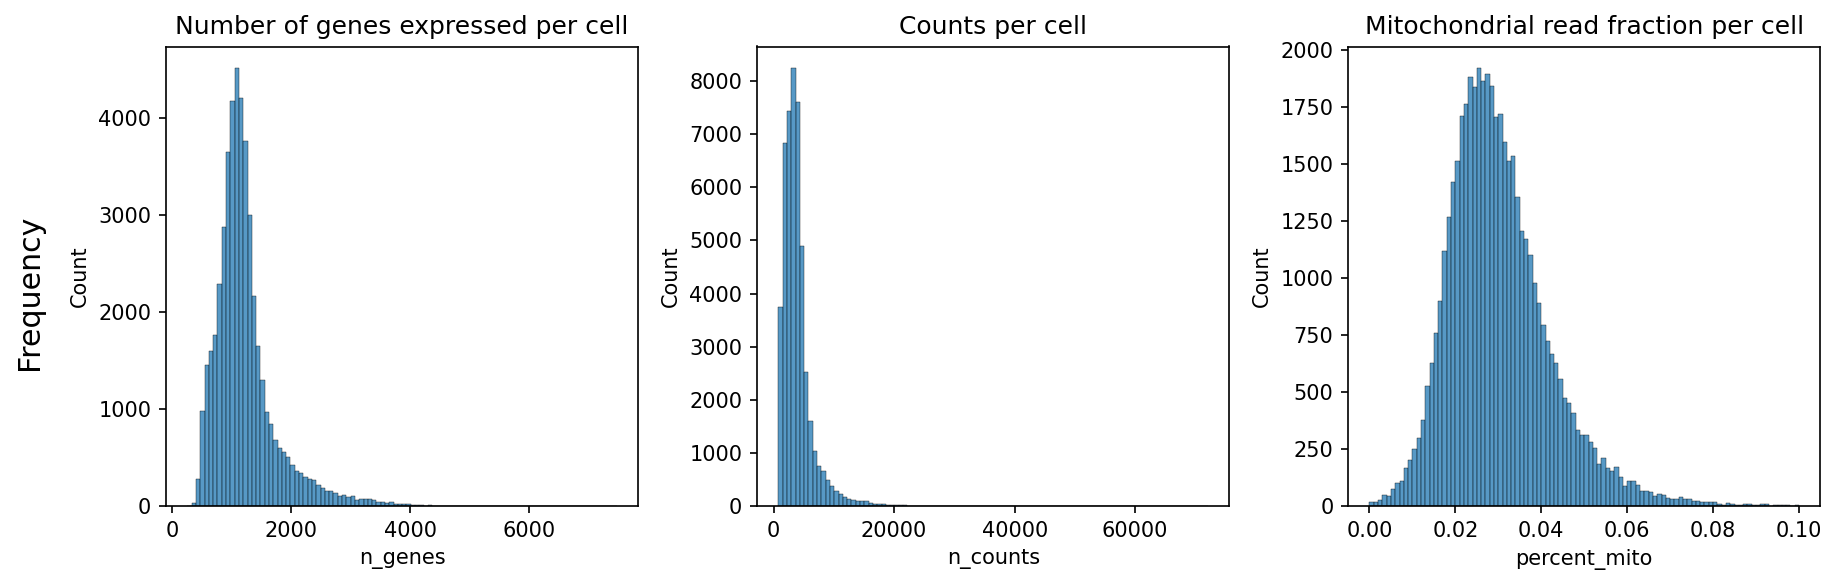

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.histplot( adata.obs['n_genes'], ax=ax1, bins=100)
sns.histplot( adata.obs['n_counts'], ax=ax2, bins=100)
sns.histplot( adata.obs['percent_mito'], ax=ax3, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

Violin Plot

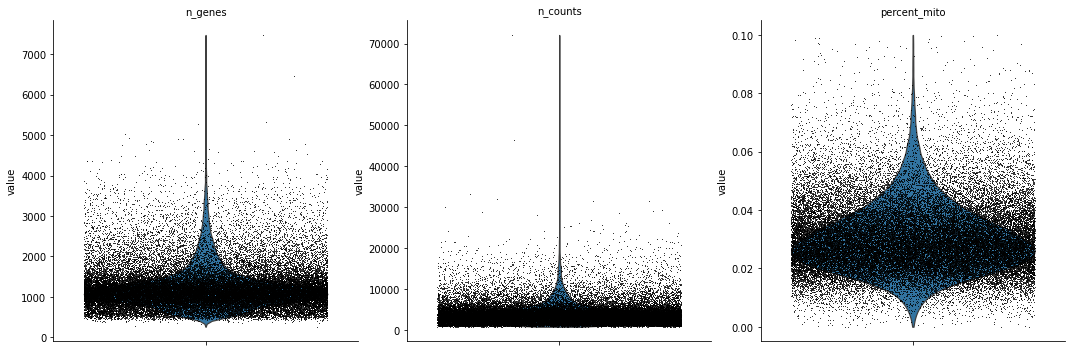

In [47]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

Scatter plot, n_genes by n_counts

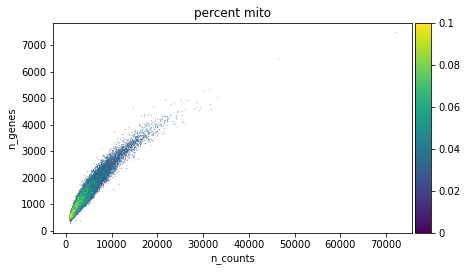

In [48]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

# Further Preprocessing

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


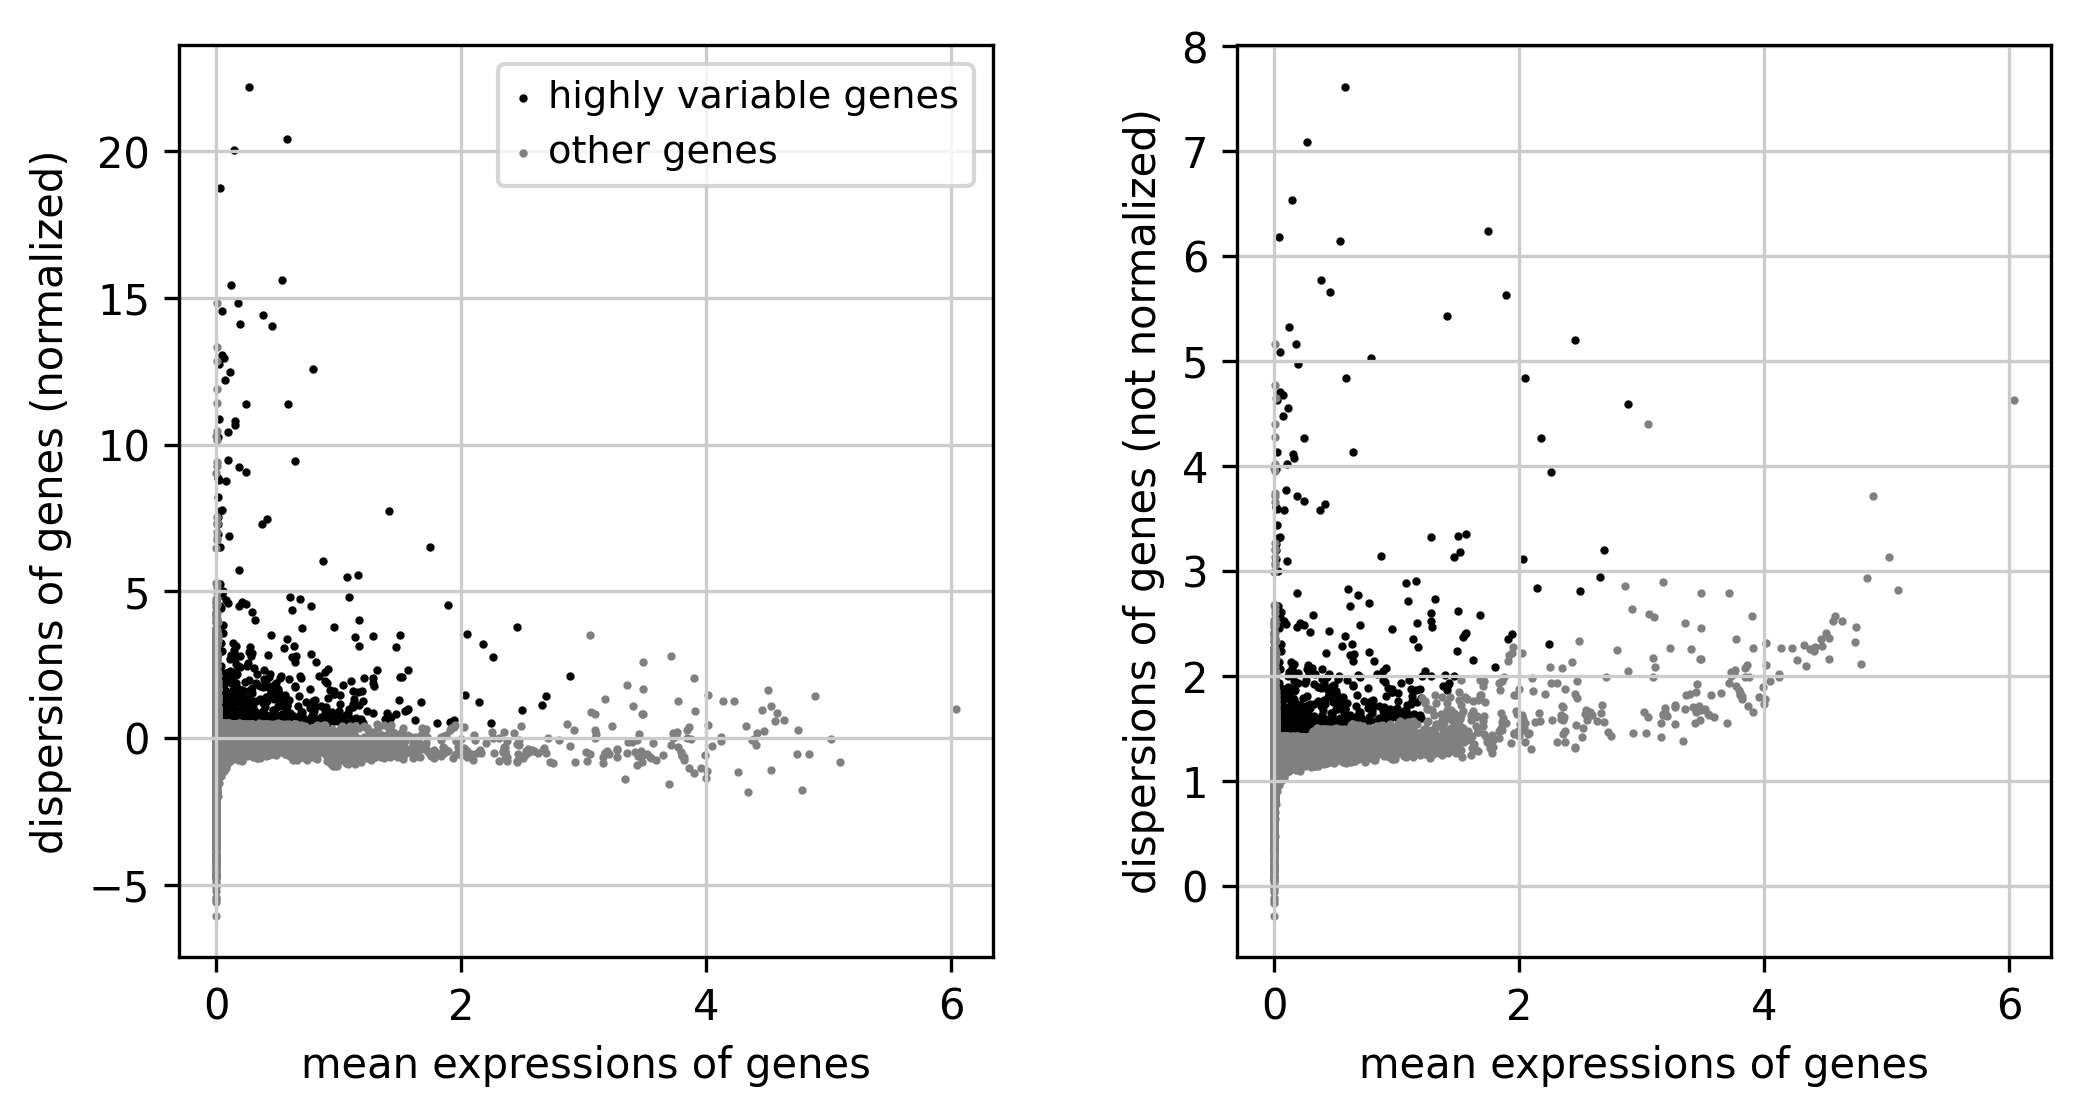

regressing out ['n_counts', 'percent_mito']


/u/home/p/priyalsh/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:01:41)


In [19]:
#Save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)



## 1 PCA

computing PCA
    with n_comps=50
    finished (0:00:06)


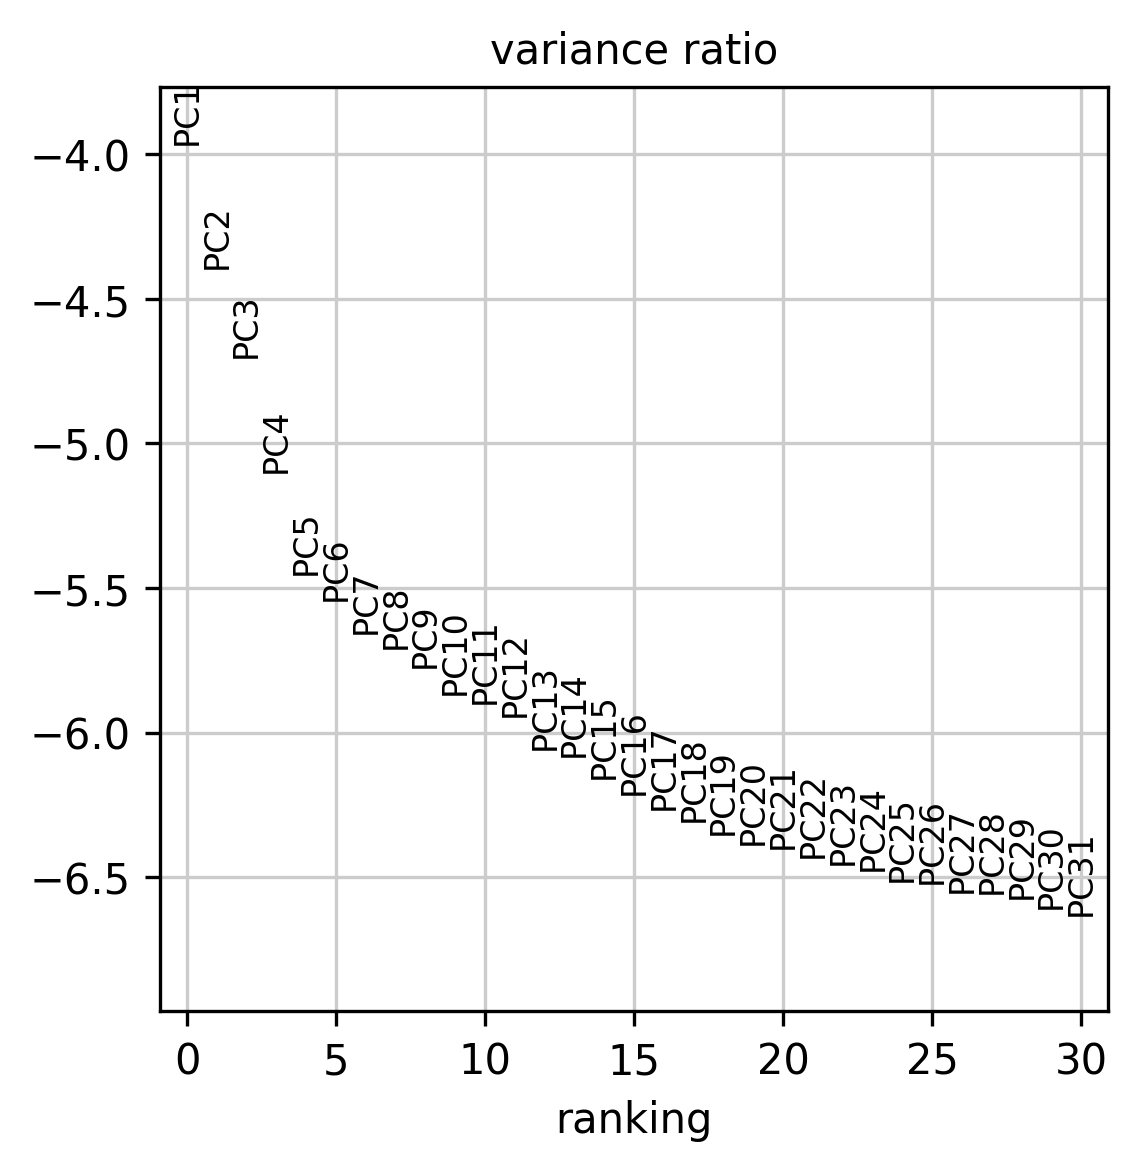

In [20]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

## Visualization of highly variable genes

In [9]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clustering

/tmp/ipykernel_32372/2757486123.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.4, random_state=42)


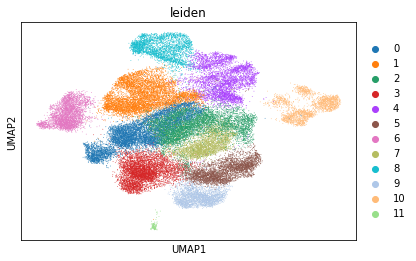

In [14]:
# Cluster the neighborhood graph with a fixed seed
sc.tl.leiden(adata, resolution=0.4, random_state=42)

# Visualize the clusters
sc.pl.umap(adata, color=['leiden'])

In [16]:
# Convert to string before combining
adata.obs['cell_state'] = adata.obs['cd_status'].astype(str) + '_' + adata.obs['stimulation'].astype(str)

# Group and calculate percentages
leiden_percentages = (
    adata.obs
    .groupby(['leiden', 'cell_state'], observed=True)
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)


desired_order = ['CD4_rest', 'CD4_act', 'CD8_rest', 'CD8_act']
leiden_percentages = leiden_percentages.reindex(columns=desired_order, fill_value=0)

print(leiden_percentages)


cell_state      CD4_rest    CD4_act   CD8_rest    CD8_act
leiden leiden                                            
0      0        1.922795  94.334361   0.499046   3.243799
1      1        0.680272  87.030464   0.207039  12.082224
2      2        5.459725  65.326792   0.743789  28.469695
3      3       95.273583   2.549520   2.059227   0.117670
4      4        1.478873   2.511737  48.051643  47.957746
5      5       45.826688   0.717703  51.967039   1.488570
6      6       84.234886   1.272780  14.318774   0.173561
7      7       31.447964  16.968326  33.096315  18.487395
8      8       82.894737   1.585695  15.317139   0.202429
9      9       94.894434   0.844530   4.184261   0.076775
10     10      33.221194  29.899075  15.222876  21.656854
11     11      28.205128  39.316239  17.094017  15.384615


/tmp/ipykernel_32372/3424377629.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs


In [17]:

# Group and calculate percentages
leiden_percentages1 = (
    adata.obs
    .groupby(['leiden', 'stimulation'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)


print(leiden_percentages1)


stimulation          act       rest
leiden leiden                      
0      0       97.578159   2.421841
1      1       99.112689   0.887311
2      2       93.796487   6.203513
3      3        2.667190  97.332810
4      4       50.469484  49.530516
5      5        2.206273  97.793727
6      6        1.446341  98.553659
7      7       35.455721  64.544279
8      8        1.788124  98.211876
9      9        0.921305  99.078695
10     10      51.555929  48.444071
11     11      54.700855  45.299145


/tmp/ipykernel_32372/2705473958.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs
/tmp/ipykernel_32372/2705473958.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs


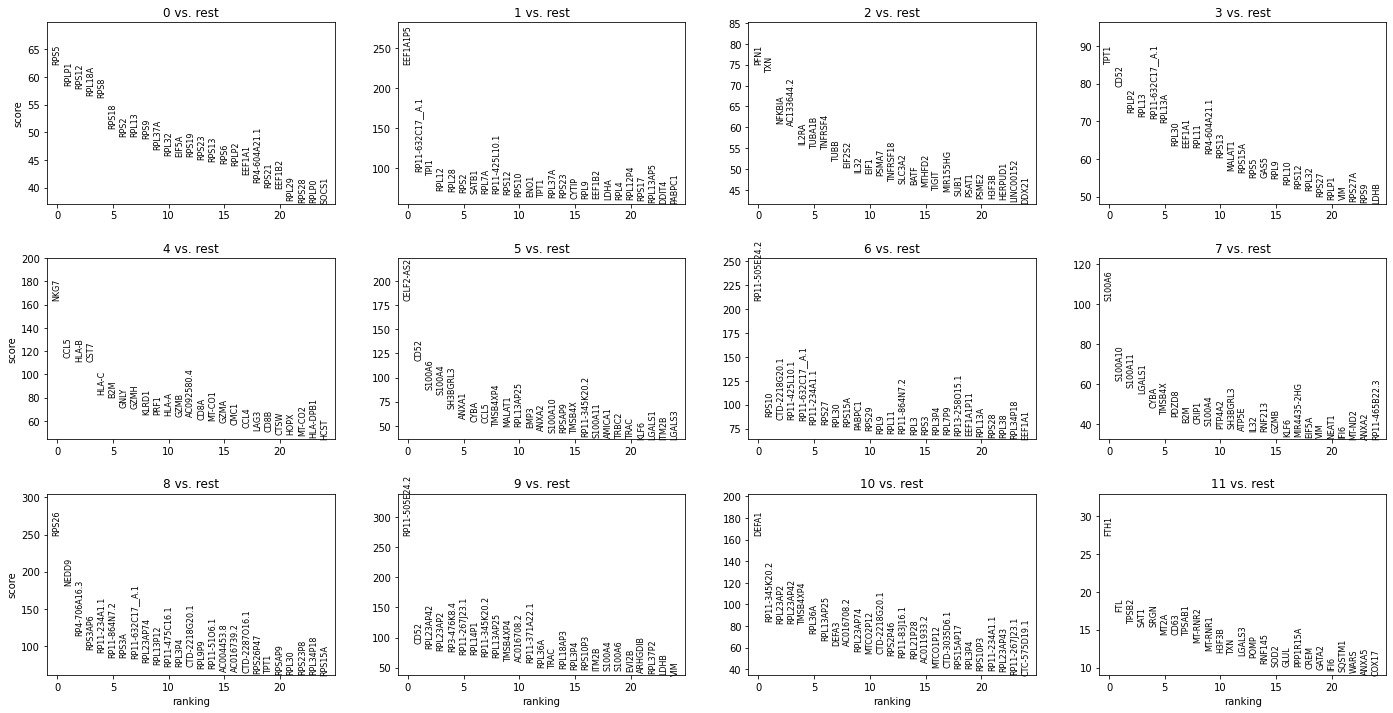

In [18]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [8]:
adata = sc.read_h5ad( f_anndata_path )

In [27]:
import loompy

# Prepare row attributes (usually genes or features)
row_attrs = {
    "Gene": np.array(adata.var.index),  # List of gene names or feature identifiers
}

# Prepare column attributes (usually cells)
col_attrs = {
    "CellID": np.array(adata.obs.index),  # List of cell IDs
    "Stimulation": np.array(adata.obs['stimulation']),  # Assuming you have a 'stimulation' column
    "CD_Status": np.array(adata.obs['cd_status']),  # Assuming you have a 'cd_status' column
    "Percent_Mito": np.array(adata.obs['percent_mito']),
    "N_Counts": np.array(adata.obs['n_counts']),
    "Leiden": np.array(adata.obs['leiden']),
    "Cell_State": np.array(adata.obs['cell_state']),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
    # Add the PCA, UMAP, and tSNE embeddings
    "X_PCA_1": np.array(adata.obsm['X_pca'][:, 0]),  # PC1
    "X_PCA_2": np.array(adata.obsm['X_pca'][:, 1]),  # PC2
    "X_UMAP_1": np.array(adata.obsm['X_umap'][:, 0]),  # UMAP component 1
    "X_UMAP_2": np.array(adata.obsm['X_umap'][:, 1]),  # UMAP component 2
    "X_tSNE_1": np.array(adata.obsm['X_tsne'][:, 0]),  # tSNE component 1
    "X_tSNE_2": np.array(adata.obsm['X_tsne'][:, 1]),  # tSNE component 2
}

loompy.create(f_pyscenic_output, adata.X.transpose(), row_attrs, col_attrs)


# PYSCENIC STEPS


##  STEP 1: Gene regulatory network inference, and generation of co-expression modules

### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. Output: List of adjacencies between a TF and its targets stored in ADJACENCIES_FNAME.

In [19]:
f_tfs = '/u/home/p/priyalsh/allTFs_hg38.txt.1'

In [20]:
with open('/u/home/p/priyalsh/allTFs_hg38.txt.1', "r") as f:
    contents = f.read()

In [16]:
!pyscenic grn pyscenic_output_5_7.loom allTFs_hg38.txt.1 -o adj5_7.csv --num_workers 20


2025-05-07 19:46:16,540 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-07 19:46:20,587 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
20 partitions
computing dask graph
/u/home/p/priyalsh/miniconda3/lib/python3.12/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 500.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
not shutting down client, client was created externally
finished

2025-05-07 19:57:07,775 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [20]:
adjacencies = pd.read_csv("adj5_7.csv", index_col=False, sep=',')

In [21]:
adjacencies.head()

,TF,target,importance
0,ANXA1,CD52,22.169544
1,NME1,SRM,20.409347
2,STAT1,CD52,19.913157
3,KLF6,ANXA1,16.263770
4,ARID5A,CD52,16.170693


# STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

locations for ranking databases, and motif annotations:

In [22]:
import glob
# ranking databases
f_db_glob = "/u/scratch/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/u/scratch/p/priyalsh/motifs-v9-nr.hgnc-m0.001-o0.0.feather"

In [41]:
!pyscenic ctx adj5_7.csv \
    /u/scratch/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather \
    --annotations_fname /u/scratch/p/priyalsh/motifs-v9-nr.hgnc-m0.001-o0.0.feather \
    --expression_mtx_fname /u/home/p/priyalsh/pyscenic_output_5_7.loom \
    --output reg5_7.csv \
    --mask_dropouts \
    --num_workers 20


2025-05-07 21:34:33,251 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-05-07 21:34:33,304 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-07 21:34:38,889 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-05-07 21:34:38,901 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-05-07 21:34:42,793 - pyscenic.utils - INFO - Creating modules.

2025-05-07 21:34:46,089 - pyscenic.cli.pyscenic - IN

# STEP 4: Cellular enrichment (aka AUCell) from CLI
It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [43]:
nGenesDetectedPerCell = np.sum(adata.X > 0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

0.01     45.0
0.05     54.0
0.10     61.0
0.50     94.0
1.00    568.0
dtype: float64


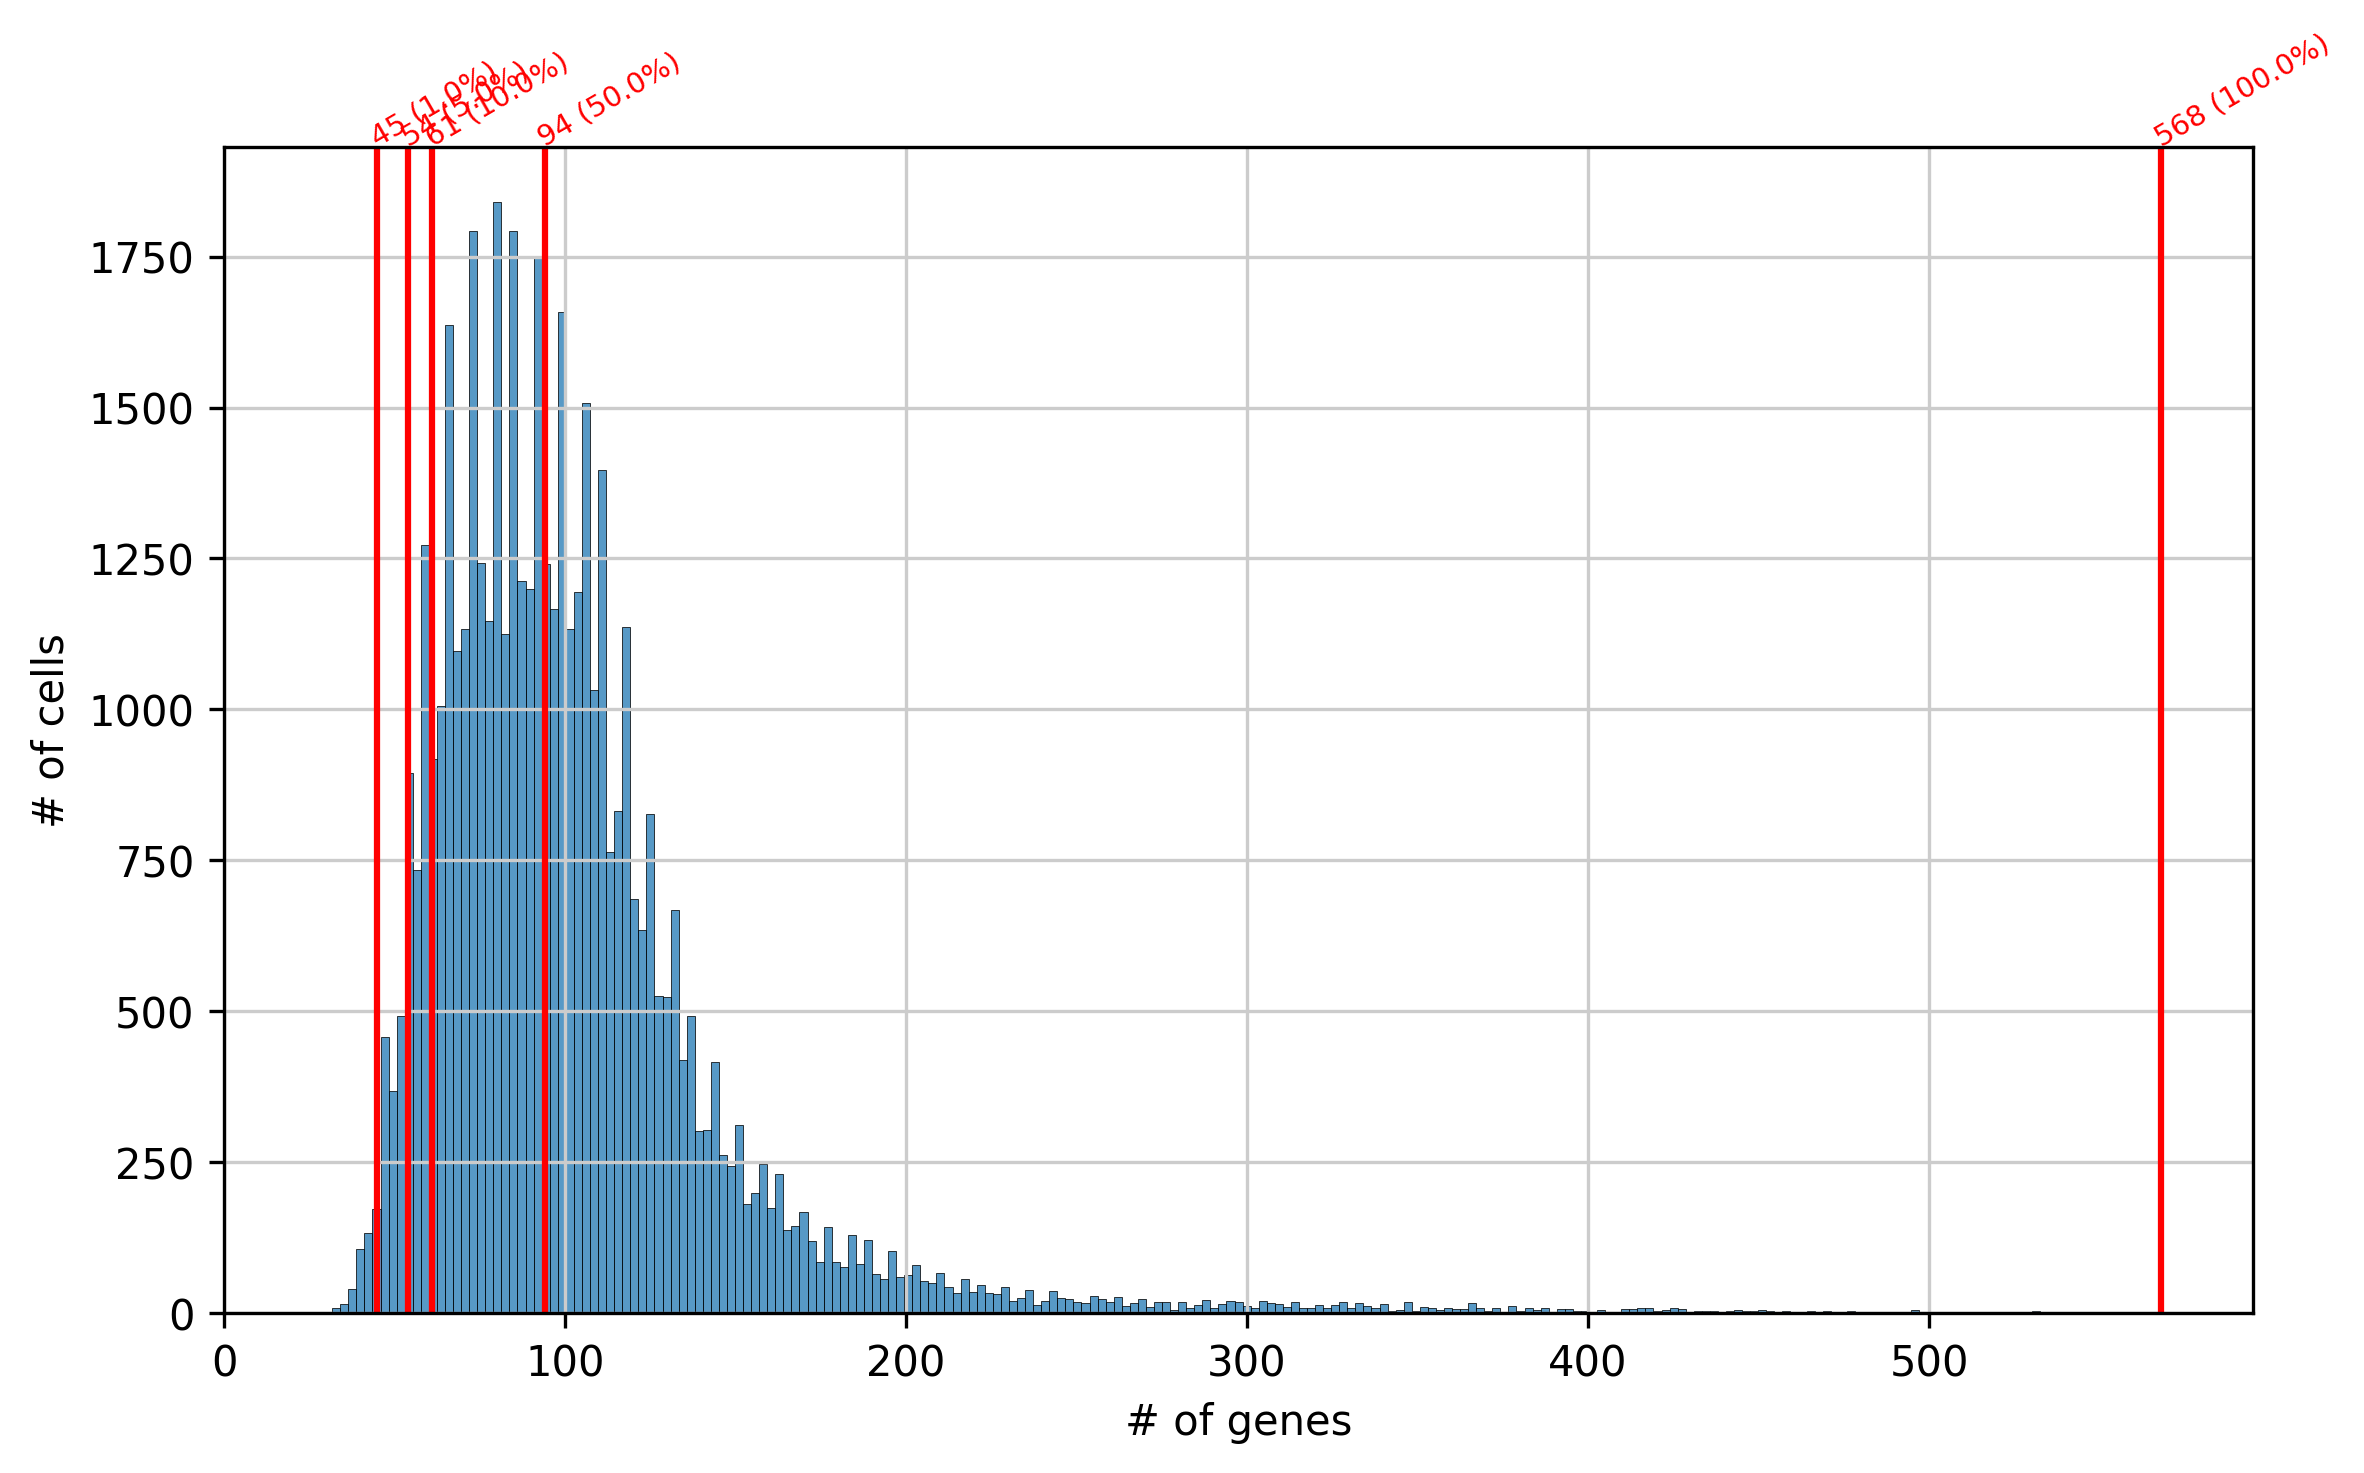

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.histplot(nGenesDetectedPerCell, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [50]:
!pyscenic aucell \
    /u/home/p/priyalsh/pyscenic_output_5_7.loom \
    /u/home/p/priyalsh/reg5_7.csv \
    --output pyscenic_output_with_auc_5_7_1023.loom \
    --num_workers 4


2025-05-07 22:23:45,409 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-07 22:23:49,113 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-05-07 22:23:50,166 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-05-07 22:24:11,985 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [3]:
import loompy as lp
import json
import zlib
import base64
f_pyscenic_output_with_auc = "pyscenic_output_with_auc_5_7_1023.loom"
# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output_with_auc, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()


In [4]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/u/home/p/priyalsh/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
# scenic output
lf = lp.connect( f_pyscenic_output_with_auc, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###


In [7]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )


In [12]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']


In [22]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Leiden_clusters_Scanpy",
        "values": list(set( adata.obs['leiden'].astype(str) ))
    },
    {
        "name": "CD_Status",
        "values": list(set(adata.obs['cd_status'].values))
    },
    {
        "name": "Stimulation",
        "values": list(set(adata.obs['stimulation'].values))
    }
   
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['leiden']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['leiden'].values.astype(np.int64)

In [23]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [26]:

col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Leiden_clusters_Scanpy": np.array(adata.obs['leiden'].values),
    "Leiden": np.array(adata.obs['leiden'].values),
    "Stimulation": np.array(adata.obs['stimulation'].values),
    "CD_Status": np.array(adata.obs['cd_status'].values),
    "Cell_State": np.array(adata.obs['cell_state'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "N_Counts": np.array(adata.obs['n_counts'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['leiden'].values),
    "X_PCA_1": np.array(adata.obsm['X_pca'][:, 0]),
    "X_PCA_2": np.array(adata.obsm['X_pca'][:, 1]),
    "X_UMAP_1": np.array(adata.obsm['X_umap'][:, 0]),
    "X_UMAP_2": np.array(adata.obsm['X_umap'][:, 1]),
    "X_tSNE_1": np.array(adata.obsm['X_tsne'][:, 0]),
    "X_tSNE_2": np.array(adata.obsm['X_tsne'][:, 1]),
}

# === Prepare row attributes ===
row_attrs = {
    "Gene": np.array(adata.var.index),
    "Regulons": regulons,
}

# === Prepare global attributes ===
attrs = {
    "title": "sampleTitle",
    "Genome": "hg38",
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": "",
}

attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [27]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close()